<a href="https://colab.research.google.com/github/hananshafi/Alzheimer-s-Detection/blob/master/Copy_of_Coding_Challenge_for_Fatima_Fellowship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. If you are reading this, you are one of our top applicants. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 4** coding challenges, and complete it. It should take you < 6 hours.

*Please do not use other tutorials or blog posts in answering these questions.*

**Due date: 3/7/2021** (don't worry about timezone, as long as it's 3/7 somewhere around the world)

# 1. Deep Learning Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick an image dataset (you can pick any dataset that you're comfortable with)
* Synthetically turn some of images upside down
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* Look at some of the images that were classified incorrectly
* *Answer the following question*: what is 1 idea that you have to improve your model's performance on this dataset (you don't have to implement it)

In [54]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 #VGG16,InceptionV3, MobileNetV2
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image
import random
import tensorflow as tf
from keras.callbacks import History


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import os
os.getcwd()

'/content'

## **Loading and Pre-processing data:**

**Dataset used:**

I have used Google streetview part_1 dataset containing 6594 images. No image augmentations have been used. 10% of data (approx. 650 images) has been separated out for testing. The data is equally divided into normal and flipped classes. 

**Pre-processing steps:**

Following steps have been carried out to pre-process the data:

1. Randomly Divide the dataset into two classes: { normal, flipped }
2. Preprocess the data and flip the images in the flipped list.
3. Separate out a test dataset for final evaluation.
4. Create labels for normal and flipped data: { normal:0, flipped:1 }
4. Finally we form our train and validation data to be fed to the model.

In [ ]:
dataset_path = "./google_streetview_dataset_part1"
image_list = os.listdir(dataset_path)



def get_train_test(img_list):
    
    test_list = random.sample(img_list, int(0.1*(len(img_list))))
    train_list = [x for x in img_list if x not in test_list]
    return train_list, test_list

def process_image(img):
        
        image = img.astype("float32")
        image /= 255.0
        image = np.expand_dims(image, axis=0)
        return image

def get_normal_flipped_arrays(data_list):
    
    flipped = random.sample(data_list, int(len(data_list)//2))
    normal = [x for x in data_list if x not in flipped]
    print(len(normal))
    flipped_lst = []
    normal_lst = []
    for img in data_list:
        image = Image.open(os.path.join(dataset_path,img))
        image = image.resize((224, 224))

        if img in normal:
            image = np.asarray(image)
            image = process_image(image)
            normal_lst.append(image)
        else:            
            flipped_image = np.rot90(image, 2)
            flipped_image = process_image(flipped_image)
            flipped_lst.append(flipped_image)
    return np.array(normal_lst), np.array(flipped_lst)



In [ ]:
train_list, test_list = get_train_test(image_list)
print(len(train_list), len(test_list))

normal_train_array, flipped_train_array = get_normal_flipped_arrays(train_list)
normal_test_array, flipped_test_array = get_normal_flipped_arrays(test_list)

In [ ]:
#create X_train and X_test

normal_train_array = normal_train_array.reshape(-1,224,224,3)
flipped_train_array = flipped_train_array.reshape(-1,224,224,3)
normal_test_array = normal_test_array.reshape(-1,224,224,3)
flipped_test_array = flipped_test_array.reshape(-1,224,224,3)

X_train = np.vstack((normal_train_array,flipped_train_array))
X_test = np.vstack((normal_test_array,flipped_test_array))

In [ ]:
# Create labels for train and test
# {0: normal, 1: flipped}

normal_train_labels=np.zeros(len(normal_train_array), dtype = int).reshape(-1,1)
flipped_train_labels=np.ones(len(flipped_train_array), dtype = int).reshape(-1,1)
normal_test_labels=np.zeros(len(normal_test_array),dtype = int).reshape(-1,1)
flipped_test_labels=np.ones(len(flipped_test_array),dtype = int).reshape(-1,1)

train_labels= np.vstack((normal_train_labels,flipped_train_labels))
test_labels = np.vstack((normal_test_labels,flipped_test_labels))

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [ ]:
#Saving the numpy versions of our data

np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

Due to upload time issues on drive / collab, the data download and processing parts have been done on my personal system. 

Here we will load the numpy versions of our data

In [57]:
#Load training and testing data

X_train = np.load("./drive/MyDrive/fatima_fellowship/X_train.npy")
y_train = np.load("./drive/MyDrive/fatima_fellowship/y_train.npy")
X_test = np.load("./drive/MyDrive/fatima_fellowship/X_test.npy")
y_test = np.load("./drive/MyDrive/fatima_fellowship/y_test.npy")

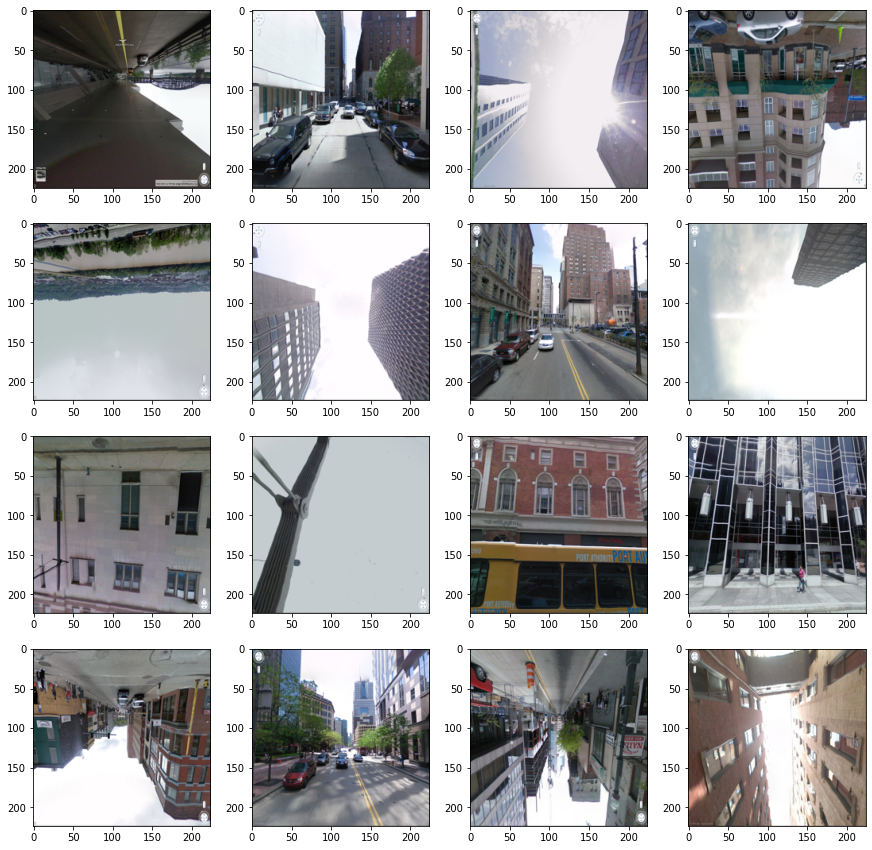

In [67]:
#Visualise some training images

w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = random.choice(X_train)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## **Methodology used: Transfer Learning**

Model training from scratch has always been a cumbersome work in deep learning tasks. Therefore to make the training efficient, I have used transfer learning. To accomplish this, I have made use of two state-of-the-art models: ResNet50 and XceptionNet, with imagenet weights, build in end-to-end fashion.

**Base Model: ResNet50**

In [16]:
#Transfer learning: Using Resnet50 Base model


def build_Resnet_Model(n_classes,lr,epochs):
  input_shape = (224, 224, 3)
  base_model = ResNet50(weights='imagenet', include_top=False,input_shape=input_shape)
  x = base_model.output
  x = Flatten()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.1)(x)
  output = Dense(n_classes, activation='softmax')(x)  
  model = Model(inputs=base_model.input, outputs=output)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=lr,decay=lr/epochs),metrics=["accuracy"])
  return model



In [10]:
# ResNet50 parameters

n_classes = 2
epochs= 10000
lr = 1e-4
BS = 128
iter_epoch = 0.8*len(X_train)//BS
save_period = 10

checkpoint_path = "./drive/MyDrive/fatima_fellowship/model_checkpoints"
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)

tb_log_path = "./drive/MyDrive/fatima_fellowship/tensorboard_logs"
if not os.path.exists(tb_log_path):
    os.mkdir(tb_log_path)
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq= int(save_period * iter_epoch))

history = History()

In [9]:
model_resnet = build_Resnet_Model(n_classes=n_classes,lr=lr, epochs=epochs)

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
model_resnet.fit(X_train,y_train,
                    steps_per_epoch = iter_epoch,
                    epochs = epochs,
                    validation_split=0.20,batch_size=BS,callbacks=[history,tensorboard_callback,cp_callback],shuffle=True)

Epoch 1/10000
37/37 [==============================] - 55s 520ms/step - loss: 1.3575 - accuracy: 0.5944 - val_loss: 0.6710 - val_accuracy: 0.5889
Epoch 2/10000
37/37 [==============================] - 17s 456ms/step - loss: 0.4036 - accuracy: 0.8276 - val_loss: 0.6627 - val_accuracy: 0.6108
Epoch 3/10000
37/37 [==============================] - 17s 456ms/step - loss: 0.3648 - accuracy: 0.8463 - val_loss: 0.5685 - val_accuracy: 0.6630
Epoch 4/10000
37/37 [==============================] - 17s 466ms/step - loss: 0.2909 - accuracy: 0.8849 - val_loss: 0.5039 - val_accuracy: 0.7094
Epoch 5/10000
37/37 [==============================] - 18s 481ms/step - loss: 0.2814 - accuracy: 0.8845 - val_loss: 0.2597 - val_accuracy: 0.9225
Epoch 6/10000
37/37 [==============================] - 18s 501ms/step - loss: 0.2520 - accuracy: 0.9039 - val_loss: 0.2273 - val_accuracy: 0.9410
Epoch 7/10000
37/37 [==============================] - 18s 497ms/step - loss: 0.2465 - accuracy: 0.9008 - val_loss: 0.4793 -

KeyboardInterrupt: ignored

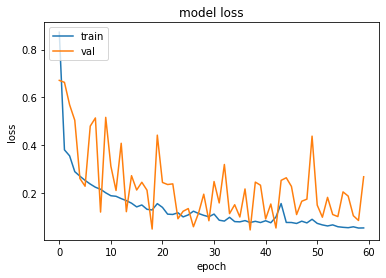

In [12]:
#Loss Plot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

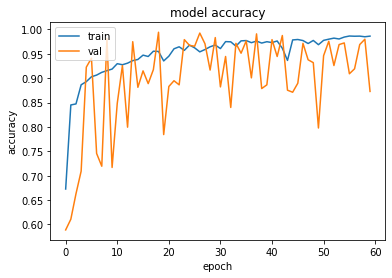

In [13]:
#Accuracy Plot


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [15]:
# Evaluate model on X_test

x = model_resnet.evaluate(X_test,y_test,
 steps = np.ceil(len(X_test) // BS)
 )

print('Test loss:' , x[0])
print('Test accuracy:',x[1])

5/5 [==============================] - 7s 974ms/step - loss: 0.1566 - accuracy: 0.9347
Test loss: 0.15660838782787323
Test accuracy: 0.9347496032714844


In [18]:
#Confusion matrix and Classification Report

y_test_ = np.argmax(y_test, axis=1)
y_pred = model_resnet.predict(X_test)
print(y_pred.shape)
y_pred_ = np.argmax(y_pred, axis=1)
print('Confusion matrix: ')
print(confusion_matrix(y_test_, y_pred_))

print("\n")

print('Classification Report: ')
target_names = ['normal','flipped']
print(classification_report(y_test_, y_pred_, target_names=target_names))


(659, 2)
Confusion matrix: 
[[288  42]
 [  1 328]]


Classification Report: 
              precision    recall  f1-score   support

      normal       1.00      0.87      0.93       330
     flipped       0.89      1.00      0.94       329

    accuracy                           0.93       659
   macro avg       0.94      0.93      0.93       659
weighted avg       0.94      0.93      0.93       659



**Using XceptionNet baseline model**

In [41]:
from tensorflow.keras.applications import Xception

def build_Xception_Model(n_classes,lr,epochs):

  input_shape = (224, 224, 3)
  base_model = Xception(include_top=False, input_shape=input_shape, weights="imagenet")
  base_model.trainable = False

  x = base_model.output
  x = Flatten()(x)
  x = Dense(256, activation="relu")(x)
  outputs = Dense(n_classes, activation="softmax")(x)
  model = Model(inputs=base_model.input, outputs=outputs)

  # for layer in base_model.layers:
  #   layer.trainable = False

  model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=lr,decay=lr/epochs),metrics=["accuracy"])
  return model


In [42]:
#Define XceptionNet Params

class XceptionNetParams():
  def __init__(self):
    self.n_classes = 2
    self.epochs= 10000
    self.lr = 1e-2
    self.BS = 128
    self.iter_epoch = 0.8*len(X_train)//BS
    self.save_period = 10

    self.checkpoint_path = "./drive/MyDrive/fatima_fellowship/xnet_model_checkpoints"
    if not os.path.exists(self.checkpoint_path):
        os.mkdir(self.checkpoint_path)

    self.tb_log_path = "./drive/MyDrive/fatima_fellowship/xnet_tensorboard_logs"
    if not os.path.exists(self.tb_log_path):
        os.mkdir(self.tb_log_path)
        
    self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.tb_log_path)


    self.cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=self.checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq= int(self.save_period * self.iter_epoch))

    self.history = History()

In [44]:
xnet_params = XceptionNetParams()
model_xnet = build_Xception_Model(n_classes=xnet_params.n_classes,lr=xnet_params.lr, epochs=xnet_params.epochs)

83689472/83683744 [==============================] - 1s 0us/step


In [46]:
model_xnet.fit(X_train,y_train,
                    steps_per_epoch = iter_epoch,
                    epochs = epochs,
                    validation_split=0.20,batch_size=xnet_params.BS,callbacks=[xnet_params.history,
                                                                xnet_params.tensorboard_callback,
                                                                xnet_params.cp_callback],shuffle=True)

Epoch 1/10000
37/37 [==============================] - 29s 799ms/step - loss: 1.1862 - accuracy: 0.9223 - val_loss: 0.4790 - val_accuracy: 0.8357
Epoch 2/10000
37/37 [==============================] - 26s 690ms/step - loss: 0.1649 - accuracy: 0.9444 - val_loss: 0.1223 - val_accuracy: 0.8837
Epoch 3/10000
37/37 [==============================] - 25s 681ms/step - loss: 0.0984 - accuracy: 0.9647 - val_loss: 0.1175 - val_accuracy: 0.9284
Epoch 4/10000
37/37 [==============================] - 25s 693ms/step - loss: 0.0749 - accuracy: 0.9751 - val_loss: 0.1068 - val_accuracy: 0.9436
Epoch 5/10000
37/37 [==============================] - 25s 687ms/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 0.1005 - val_accuracy: 0.9528
Epoch 6/10000
37/37 [==============================] - 25s 683ms/step - loss: 0.0411 - accuracy: 0.9870 - val_loss: 0.0729 - val_accuracy: 0.9747
Epoch 7/10000
37/37 [==============================] - 25s 685ms/step - loss: 0.0328 - accuracy: 0.9905 - val_loss: 0.1055 -

KeyboardInterrupt: ignored

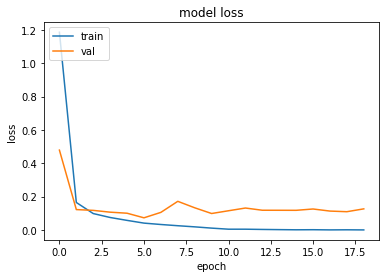

In [47]:
#Loss Plot

plt.plot(xnet_params.history.history['loss'])
plt.plot(xnet_params.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

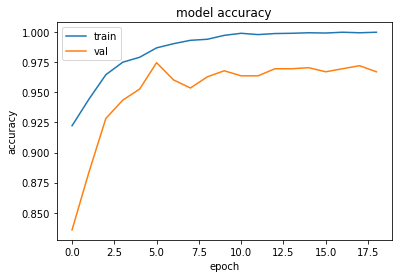

In [48]:
#Accuracy Plot


plt.plot(xnet_params.history.history['accuracy'])
plt.plot(xnet_params.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
# Evaluate model on test data

xnet_eval = model_xnet.evaluate(X_test,y_test,
 steps = np.ceil(len(X_test) // BS)
 )

print('Test loss:' , xnet_eval[0])
print('Test accuracy:',xnet_eval[1])

5/5 [==============================] - 11s 2s/step - loss: 0.0950 - accuracy: 0.9788
Test loss: 0.09499605745077133
Test accuracy: 0.9787557125091553


In [50]:
#Confusion matrix and Classification Report

y_pred = model_efnet.predict(X_test)
y_pred_ = np.argmax(y_pred, axis=1)

print('Confusion matrix: ')
print(confusion_matrix(y_test_, y_pred_))

print("\n")

print('Classification Report: ')
target_names = ['normal','flipped']
print(classification_report(y_test_, y_pred_, target_names=target_names))


Confusion matrix: 
[[323   7]
 [  7 322]]


Classification Report: 
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98       330
     flipped       0.98      0.98      0.98       329

    accuracy                           0.98       659
   macro avg       0.98      0.98      0.98       659
weighted avg       0.98      0.98      0.98       659



**Visualising the misclassified examples from XceptionNet model**

Actual Label: Normal 	 Predicted_Label: Flipped


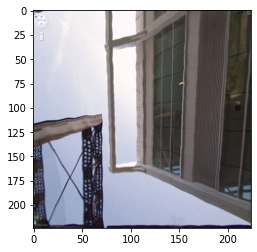

***************
Actual Label: Normal 	 Predicted_Label: Flipped


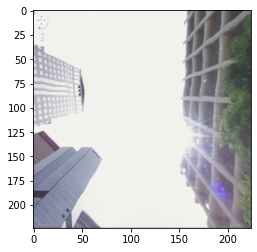

***************
Actual Label: Normal 	 Predicted_Label: Flipped


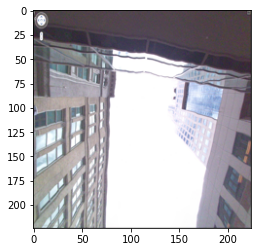

***************
Actual Label: Normal 	 Predicted_Label: Flipped


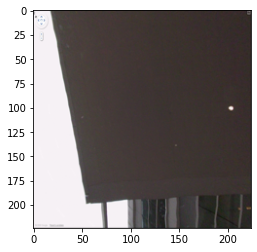

***************
Actual Label: Normal 	 Predicted_Label: Flipped


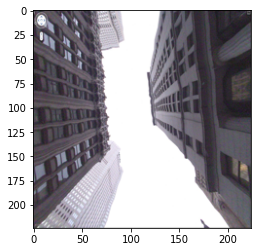

***************
Actual Label: Normal 	 Predicted_Label: Flipped


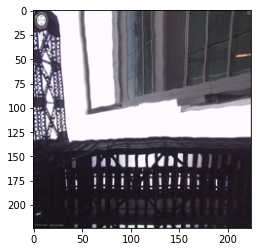

***************
Actual Label: Normal 	 Predicted_Label: Flipped


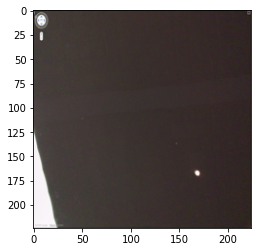

***************
Actual Label: Flipped 	 Predicted_Label: Normal


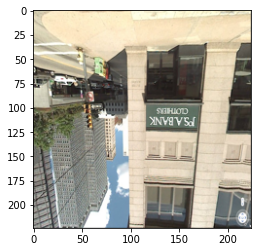

***************
Actual Label: Flipped 	 Predicted_Label: Normal


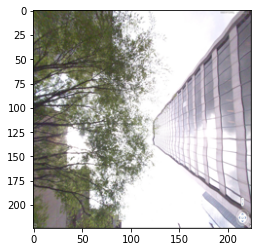

***************
Actual Label: Flipped 	 Predicted_Label: Normal


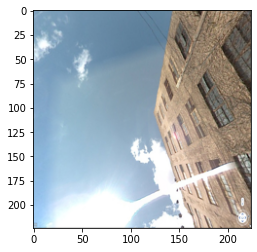

***************
Actual Label: Flipped 	 Predicted_Label: Normal


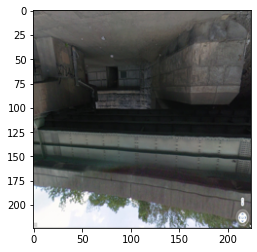

***************
Actual Label: Flipped 	 Predicted_Label: Normal


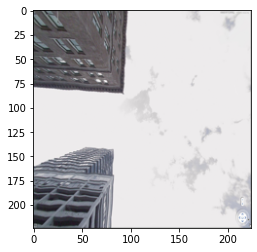

***************
Actual Label: Flipped 	 Predicted_Label: Normal


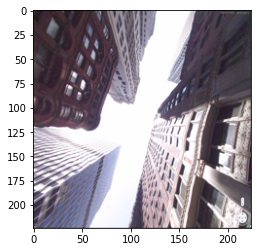

***************
Actual Label: Flipped 	 Predicted_Label: Normal


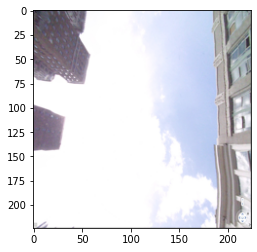

***************


In [53]:
# Visualise misclassified images

label_dict = {0: 'Normal', 1:'Flipped'}
def vis_misclassified_images(X_test,y_test,y_pred):
  for image, label, pred in zip(X_test,y_test,y_pred):
    if label != pred:
      
      print("Actual Label: {} \t Predicted_Label: {}".format(label_dict[label],label_dict[pred]))
      plt.figure()
      plt.imshow(image)
      plt.show()

      print("*"*15)

vis_misclassified_images(X_test,y_test_,y_pred_)


# Future work and improvements

We have seen how CNN's (using transfer learning) could be effective in determining whether an image is normal or upside-down. However, it is important to note here that such method is effective only when images belong to same domain (in our cases: street / buildings). When applied to out-of-domain image samples, it is highly likely that our model will fail. Domain adaptation in deep learning is an interesting topic and hence presents a challenging research area. 


While in our case the dataset was balanced, however, in the real world scenarios, the upside-downs images might be limited which could lead to an imbalanced dataset. In such a scenario, it we can use some data-balancing techniques such as: class weights, over / under sampling.

If we have broader look at this topic, we can't neglect the possibility of images with mixed orientations (any orientation between 0 to 360 degrees). In such case, the problem gets modified because we now have to detect 360 classes rather than 2 classes.



**what is 1 idea that you have to improve your model's performance on this dataset (you don't have to implement it)**

From the visualisation of misclassified samples, we have seen that the model mostly misclassifies top view (sky) images. This is because the image orientation whether in the case of upside down or normal, isn't much differentiable from the original one, as can be seen from the images in such cases. Such images are infact hard for even a normal human to detect (we won't blame the model in this case). 

However, as a general rule of thumb, to improve the performance of the model, we can increase our dataset (more data, better the model) by including more variants of data or augmenting the existing images (without using the rotation or shfting operations). In our data, it's somewhat obvious that for normal images, the sky will mostly appear near the top region of images and roads / pedestrians / roads etc. would appear in the lower regions of image. For the flipped images, the case will be vice versa mostly. Therefore by adding more data samples will increase the efficiency. In addition to this, the google streetview data has limited lanes / streets captured from downtown and pittsburgh areas. By including data from other regions with different infrastructure styles, the model could become more robust and scalable.




